## Prepping Environment

In [ ]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
# Training, validation, and test datasets (60/20/20 split)

#train = pd.read_csv("FILE PATH/training.csv", index_col = None) 
#validation = pd.read_csv("FILE PATH/validation.csv", index_col = None)
#test = pd.read_csv("FILE PATH/test.csv", index_col = None)

train = pd.read_csv("../Datasets/cov_filtered_3.5_training.csv", index_col = None) 
validation = pd.read_csv("../Datasets/cov_filtered_3.5_validation.csv", index_col = None)
test = pd.read_csv("../Datasets/cov_filtered_3.5_test.csv", index_col = None)

## Relabels Classification Column in Datasets

In [5]:
# Renaming the classifications as numbers

#labels = pd.read_csv("FILE PATH/labels.csv")

labels = pd.read_csv("../Datasets/labels.csv")
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,1]] = i
train["Classification"].replace(labels_dict, inplace=True)
validation["Classification"].replace(labels_dict, inplace=True)
test["Classification"].replace(labels_dict, inplace=True)

In [6]:
# Splitting gene expression data and classifications for training, validation, and test
size = train.shape[1] - 1
x = train.iloc[:, 1:size]
y = train.iloc[:, [size]]
x_val = validation.iloc[:,1:size]
y_val = validation.iloc[:,[size]]
x_test = test.iloc[:,1:size]
y_test = test.iloc[:,[size]]

## Training the model

In [19]:
%%time

# Default
#clf = LogisticRegression(penalty='l2', solver="lbfgs", max_iter=100, n_jobs=-1)

# Optimal
clf = LogisticRegression(random_state=123456, penalty='l2', solver="newton-cg", max_iter=100, multi_class="multinomial", n_jobs=-1)

clf.fit(x, y.values.ravel())

## Model Prediction

#### Run only one box of the three below

In [21]:
# Run this to predict on training set
y_pred = clf.predict(x)
#pred_df = pd.DataFrame(y_pred)
#pred_df.to_csv("./lr_multi_optimal_training_cov_3.5_pred.csv")
cm = pd.DataFrame(metrics.confusion_matrix(y, y_pred))
print("Cohen's Kappa: ", metrics.cohen_kappa_score(y, y_pred))

0.934181312995156

In [24]:
# Run this to predict on validation set
y_pred = clf.predict(x_val)
cm = pd.DataFrame(metrics.confusion_matrix(y_val, y_pred))
print("Cohen's Kappa: ", metrics.cohen_kappa_score(y_val, y_pred))

1.0

In [27]:
# Run this to predict on testing set
y_pred = clf.predict(x_test)
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
print("Cohen's Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

0.9362213796881658

In [28]:
# Saving validation and testing predictions
#y_pred_val = clf.predict(x_val)
#y_pred_test = clf.predict(x_test)
#pred_df = pd.DataFrame(y_pred_val)
#pred_df.columns = ["Validation"]
#pred_df["Test"] = y_pred_test
#pred_df.to_csv("./lr_multi_optimal_ValAndTest_cov_0.52_pred.csv")

Text(0, 0.5, 'F-beta Score')

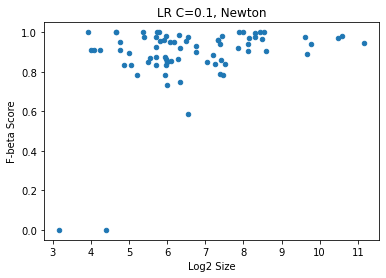

In [29]:
# Creating confusion matrix
new_cm = pd.DataFrame(columns = ["TN", "FP", "FN", "TP"])
for i in range(75):
    true_negative = 0
    for j in range(75):
        if j == i:
            continue
        true_negative += sum(cm[j][0:i].append(cm[j][i+1:]))
    new_cm.loc[i] = [true_negative, sum(cm[i][0:i].append(cm[i][i+1:])), sum(cm.iloc[i][0:i].append(cm.iloc[i][i+1:])), cm[i][i]]
cm = new_cm
# Number of cells per preassigned cluster

#dataset_sizes = pd.read_csv("FILE PATH/subset_sizes.csv", header = None)

labels = pd.read_csv("../Datasets/labels.csv")
dataset_sizes = pd.read_csv("../Datasets/subset_sizes.csv", header = None)
cm["TN"] = cm["TN"].astype(np.int64)
cm["FP"] = cm["FP"].astype(np.int64)
cm["FN"] = cm["FN"].astype(np.int64)
cm["TP"] = cm["TP"].astype(np.int64)
# Precision calculation
cm = cm.assign(precision = cm["TP"] / (cm["TP"] + cm["FP"]))
cm["precision"].astype(np.float64)
# Recall calculation
cm = cm.assign(recall = cm["TP"] / (cm["TP"] + cm["FN"]))
cm["recall"].astype(np.float64)
# Fbeta calculation
cm = cm.assign(fbeta = (1 + 0.5 ** 2) * (cm["precision"] * cm["recall"]) / ((0.5 ** 2 * cm["precision"]) + cm["recall"]))
cm["fbeta"].fillna(0, inplace=True)
cm["cluster"] = labels["0"]
cm = cm.merge(dataset_sizes, how = 'inner', left_on='cluster', right_on=0)
cm.drop(columns=0, inplace = True)
cm.rename(columns={1:"size"}, inplace = True)
cm["log_size"] = np.log2(cm["size"])

In [ ]:
# Final confusion matrix with Fbeta scores
cm

## Plotting

Text(0, 0.5, 'F-beta Score')

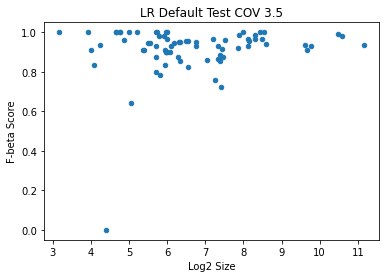

In [38]:
fig = cm.plot.scatter(x="log_size", y="fbeta", title="LR Optimal Test COV 3.5", ylim=[-0.05,1.05]).get_figure()
plt.xlabel("Log2 Size")
plt.ylabel("F-beta Score")

## Saving Confusion Matrix

In [30]:
cm.to_csv("./lr_multi_optimal_test_cov_0.52.csv")